In [19]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

import os

In [20]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [21]:
data_dir = pathlib.Path('../raw_data/midi_chopin_format_0_dataset/')
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 132


### Process a MIDI file

In [22]:
sample_file = filenames[1]
print(sample_file)

../raw_data/midi_chopin_format_0_dataset/chpn_op25_e12_format0.mid


In [23]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [24]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [25]:
#display_audio(pm)

In [26]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Bright Acoustic Piano


In [28]:
#pm2 = pretty_midi.PrettyMIDI('../raw_data/midi_format_1/3123a_berceuse_(c)smythe.mid')

In [29]:
#print('Number of instruments:', len(pm2.instruments))
#instrument = pm2.instruments[0]
#instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
#print('Instrument name:', instrument_name)

### Extract notes

In [30]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=36, note_name=C2, duration=0.1055
1: pitch=51, note_name=D#3, duration=0.1055
2: pitch=43, note_name=G2, duration=0.1033
3: pitch=55, note_name=G3, duration=0.1033
4: pitch=48, note_name=C3, duration=0.1009
5: pitch=63, note_name=D#4, duration=0.1009
6: pitch=48, note_name=C3, duration=0.0987
7: pitch=63, note_name=D#4, duration=0.0987
8: pitch=55, note_name=G3, duration=0.0973
9: pitch=67, note_name=G4, duration=0.0973


In [31]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [32]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,36,0.000000,0.105506,0.000000,0.105506
1,51,0.000000,0.105506,0.000000,0.105506
2,43,0.106386,0.209694,0.106386,0.103308
3,55,0.106386,0.209694,0.000000,0.103308
4,48,0.210557,0.311413,0.104170,0.100856


In [33]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C2', 'D#3', 'G2', 'G3', 'C3', 'D#4', 'C3', 'D#4', 'G3', 'G4'],
      dtype='<U3')

In [34]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

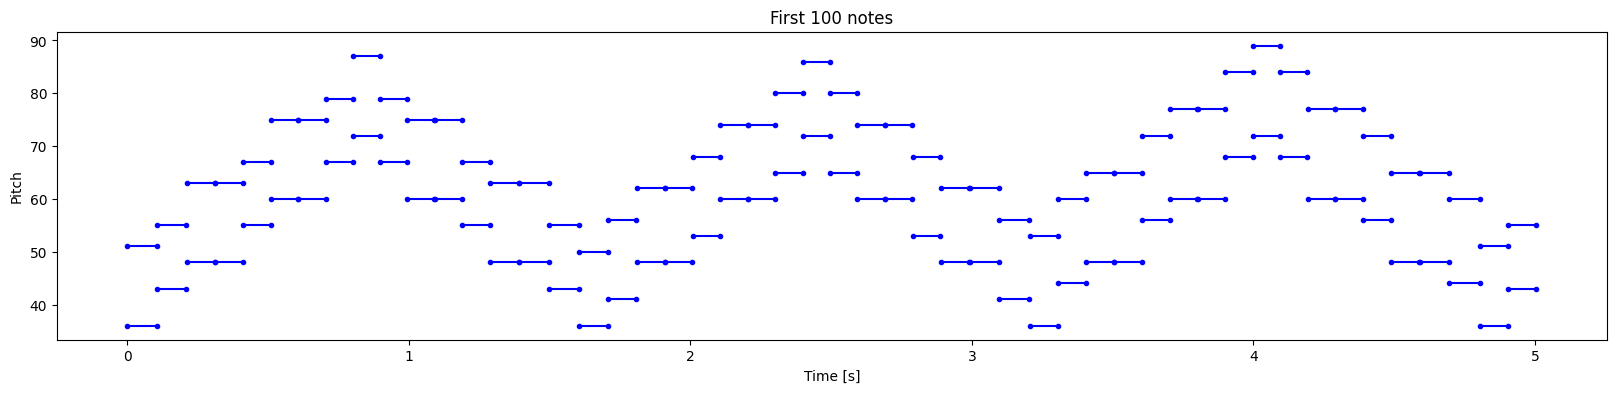

In [35]:
plot_piano_roll(raw_notes, count=100)


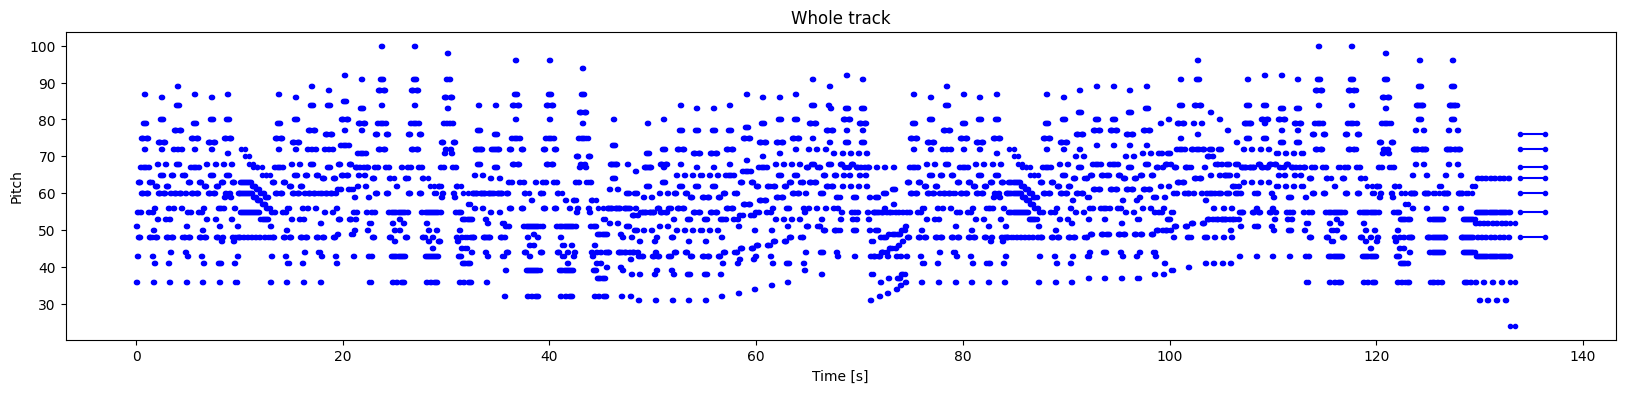

In [36]:
plot_piano_roll(raw_notes)


In [37]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

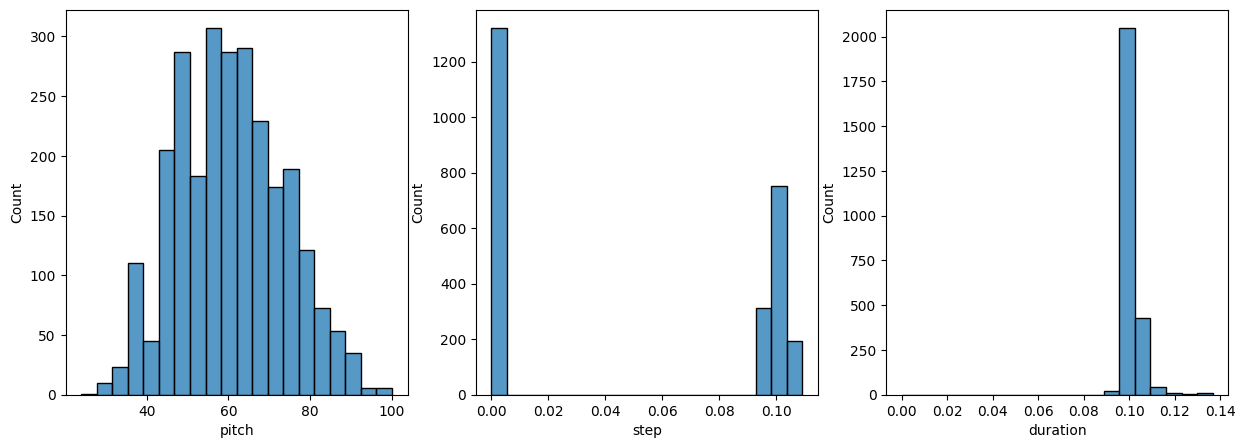

In [38]:
plot_distributions(raw_notes)


### Create a MIDI file

In [39]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [40]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [41]:
#display_audio(example_pm)

### Create the training dataset

In [ ]:
try :
    print(os.ttyname(r)) 
     
except OSError as error :
    print(error)

In [48]:
num_files = len(filenames)
all_notes = []
for f in filenames[:num_files]:
    try:
        notes = midi_to_notes(f)
        all_notes.append(notes)
    except OSError:
        continue

all_notes = pd.concat(all_notes)

/Users/aurelie_emma/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [55]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 260589


In [56]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [57]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [66]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [67]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [68]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[0.3828125  0.         0.4031175 ]
 [0.6015625  0.         0.60467625]
 [0.4375     0.4031175  0.411173  ]
 [0.5703125  0.20155875 0.20961425]
 [0.53125    0.20961425 1.5375    ]
 [0.5078125  0.         1.5375    ]
 [0.4765625  0.         1.5375    ]
 [0.4375     0.4192285  0.36075965]
 [0.4375     0.379747   0.35403745]
 [0.4375     0.372671   0.34756082]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=73.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.7087952499999997>}


In [86]:
batch_size = 16
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [87]:
train_ds.element_spec

(TensorSpec(shape=(16, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(16,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(16,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(16,), dtype=tf.float64, name=None)})

### Create and train the model

In [88]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [89]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [90]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2022-12-06 12:52:25.693110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 167172 of 260539


     30/Unknown - 16s 6ms/step - loss: 5.1471 - duration_loss: 0.2574 - pitch_loss: 4.8630 - step_loss: 0.0267

2022-12-06 12:52:31.336881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


16283/16283 [==============================] - 104s 5ms/step - loss: 5.1127 - duration_loss: 0.2189 - pitch_loss: 4.8647 - step_loss: 0.0291


{'loss': 5.112704753875732,
 'duration_loss': 0.2188817262649536,
 'pitch_loss': 4.864706039428711,
 'step_loss': 0.029125625267624855}

In [91]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [92]:
model.evaluate(train_ds, return_dict=True)

16283/16283 [==============================] - 87s 5ms/step - loss: 0.4912 - duration_loss: 0.2189 - pitch_loss: 4.8647 - step_loss: 0.0291


{'loss': 0.4912419021129608,
 'duration_loss': 0.2188817262649536,
 'pitch_loss': 4.864706039428711,
 'step_loss': 0.029125625267624855}

In [93]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [94]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
16283/16283 [==============================] - 260s 16ms/step - loss: 0.3404 - duration_loss: 0.1238 - pitch_loss: 3.8796 - step_loss: 0.0227
Epoch 2/100
16283/16283 [==============================] - 257s 16ms/step - loss: 0.3287 - duration_loss: 0.1186 - pitch_loss: 3.7861 - step_loss: 0.0208
Epoch 3/100
16283/16283 [==============================] - 263s 16ms/step - loss: 0.3236 - duration_loss: 0.1164 - pitch_loss: 3.7359 - step_loss: 0.0204
Epoch 4/100
16283/16283 [==============================] - 262s 16ms/step - loss: 0.3199 - duration_loss: 0.1145 - pitch_loss: 3.7060 - step_loss: 0.0201
Epoch 5/100
16283/16283 [==============================] - 274s 17ms/step - loss: 0.3165 - duration_loss: 0.1125 - pitch_loss: 3.6827 - step_loss: 0.0199
Epoch 6/100
16283/16283 [==============================] - 276s 17ms/step - loss: 0.3144 - duration_loss: 0.1113 - pitch_loss: 3.6663 - step_loss: 0.0198
Epoch 7/100
16283/16283 [==============================] - 281s 17ms/step - 

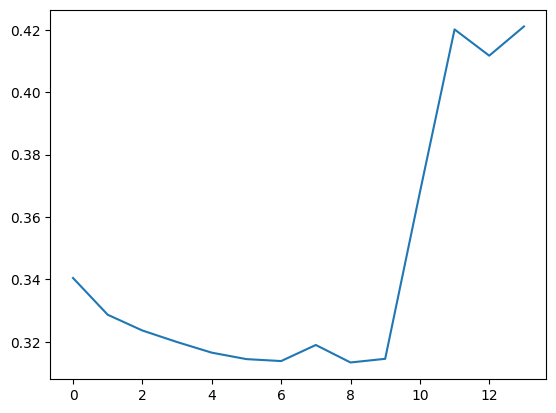

In [95]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [96]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [97]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 12ms/step


In [98]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,75,0.092539,0.153342,0.092539,0.245881
1,89,0.203381,0.000000,0.295920,0.295920
2,88,0.224740,0.000000,0.520660,0.520660
3,86,0.229709,0.000000,0.750369,0.750369
4,97,0.232537,0.000000,0.982906,0.982906
5,79,0.233702,0.000000,1.216608,1.216608
6,86,0.234640,0.000000,1.451248,1.451248
7,80,0.236024,0.000000,1.687272,1.687272
8,95,0.235942,0.000000,1.923214,1.923214
9,95,0.238149,0.000000,2.161363,2.161363


In [99]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)

In [100]:
test_directory_path = '../raw_data/tests/'
filename = 'tensorflow_baseline_output.mid'
out_pm.write(os.path.join(test_directory_path, filename))

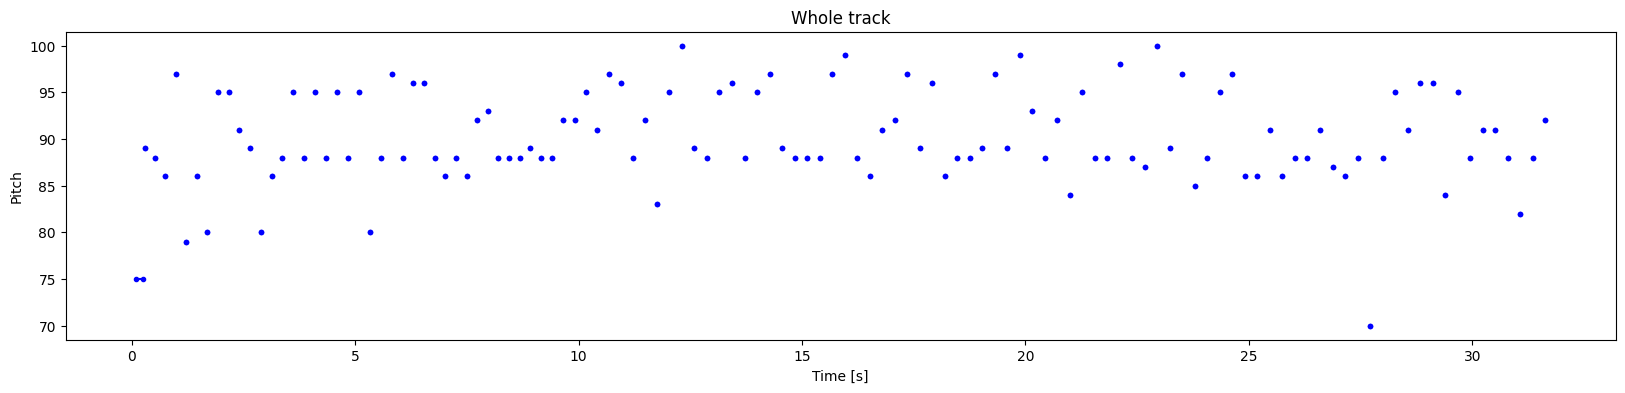

In [101]:
plot_piano_roll(generated_notes)

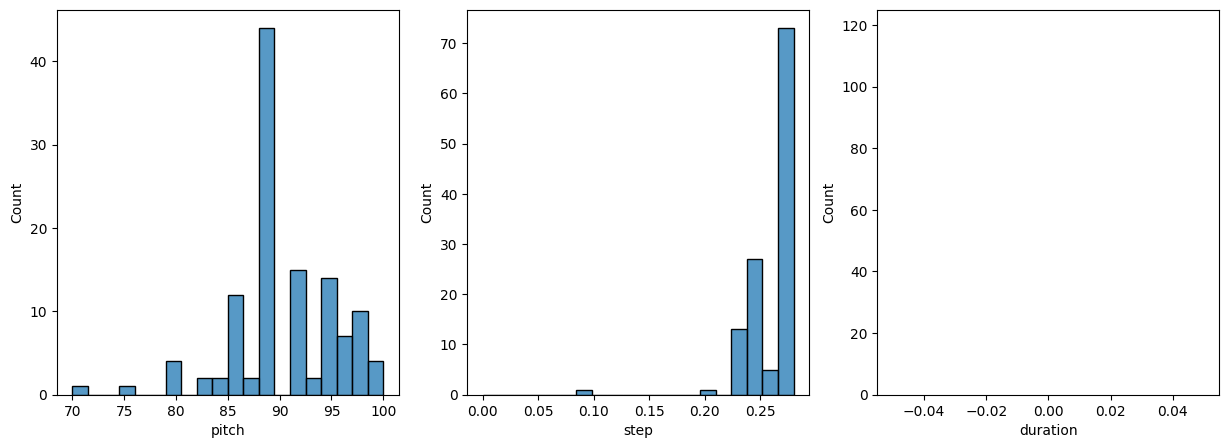

In [102]:
plot_distributions(generated_notes)